In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F



---


# **Recording**




[Maman 12 Q2](https://drive.google.com/file/d/1oh7funSiHGqCn7P-ZDbzaScCbpeEqstc/view?usp=sharing)


---



---





---


# **Question 2**

---



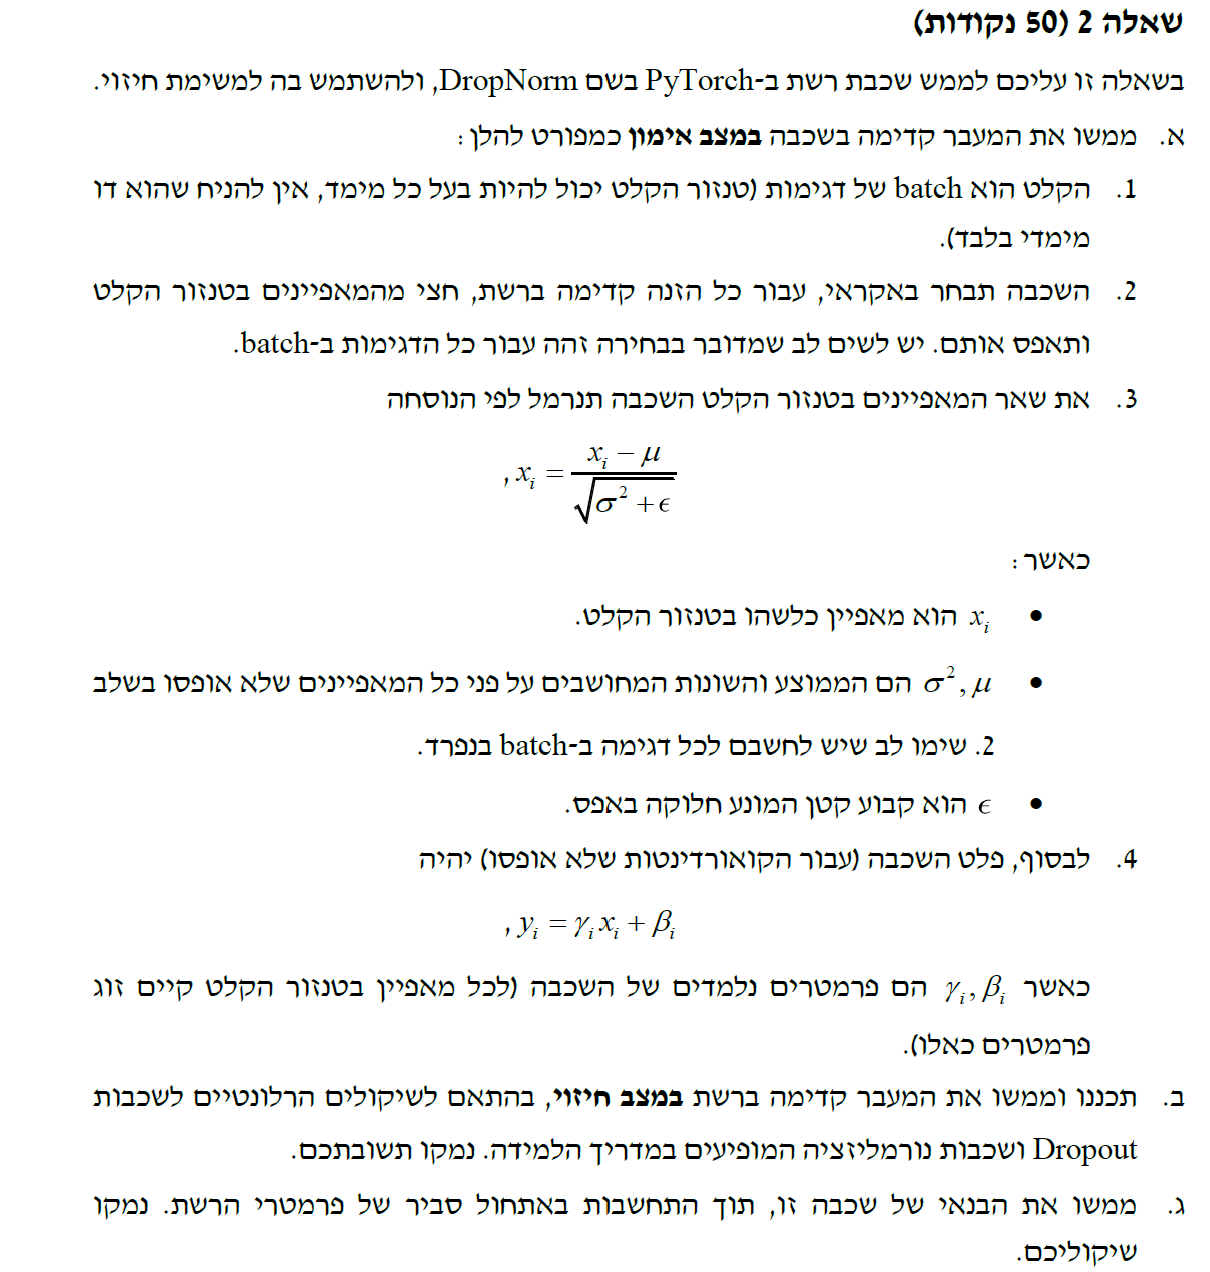

In [4]:
def set_cpu():
  device_in = torch.device('cpu')
  return device_in


device = set_cpu()
print(device)

cpu


In [ ]:
def get_drop_mask(drop_rate, len):
  #  return (torch.rand(len) > dropout).float().to(device)
  mask = torch.zeros(len).float().to(device)
  indxs = torch.randperm(len)
  indx_to_keep = indxs[int(len*drop_rate):]
  mask[indx_to_keep] = 1
  # print(f"\nMask for {drop_rate*100}% dropout:", mask, "Indexes to keep:", indx_to_keep, sep="\n")

  indx_to_keep.to(device)
  mask.to(device)
  return mask, indx_to_keep


"""
dropout_batch gets:
  batch - a batch of FLATTENED samples (dimension = 2)
  dropout - percentage of samples to be dropped
  
applies dropout accordingly
"""
def dropout_batch(batch, dropout):
        assert 0 <= dropout <= 1
        
        # In this case, all elements are dropped out
        if dropout == 1:
            return torch.zeros_like(batch)
        # In this case, all elements are kept
        if dropout == 0:
            return batch
        mask, indexes_to_keep = get_drop_mask(dropout, batch.size(1))
        mask.to(device)
        indexes_to_keep.to(device)
        return mask * batch, indexes_to_keep

# **Sanity check for Dropout**


In [ ]:
shape1 = (2, 2, 8)
x1= torch.arange(1, 33, dtype = torch.float32).reshape(shape1)
print("\n\n---------------","Original Tensor:", x1, sep="\n")

f1 = x1.flatten(1)
print("\n\n---------------", "Flattened Tensor:", f1, sep="\n")

d0, keep0 = dropout_batch(f1, 0.)
print("\n\n---------------", "Dropout 0%:",d0, sep="\n")

d1, keep1 = dropout_batch(f1, 0.5)
print("\n\n---------------", "Dropout 50%:", d1, "Dropout 50% back to shape:", d1.reshape(shape1), sep="\n")

d2, keep2 = dropout_batch(f1, 1.)
print("\n\n---------------", "Dropout 100%:", d2, sep="\n")



---------------
Original Tensor:
tensor([[[ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.],
         [ 9., 10., 11., 12., 13., 14., 15., 16.]],

        [[17., 18., 19., 20., 21., 22., 23., 24.],
         [25., 26., 27., 28., 29., 30., 31., 32.]]])


---------------
Flattened Tensor:
tensor([[ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
         15., 16.],
        [17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27., 28., 29., 30.,
         31., 32.]])


---------------
Dropout 0%:
tensor([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
        15., 16.])


---------------
Dropout 50%:
tensor([[ 1.,  2.,  0.,  0.,  5.,  0.,  7.,  0.,  9., 10.,  0.,  0.,  0., 14.,
          0., 16.],
        [17., 18.,  0.,  0., 21.,  0., 23.,  0., 25., 26.,  0.,  0.,  0., 30.,
          0., 32.]])
Dropout 50% back to shape:
tensor([[[ 1.,  2.,  0.,  0.,  5.,  0.,  7.,  0.],
         [ 9., 10.,  0.,  0.,  0., 14.,  0., 16.]],

        [[17., 18.,  0.,  0., 21.,

In [ ]:
"""
drop_and_normalize_batch
gets:
  batch - a batch of FLATTENED samples (dimension = 2)
  drop_rate - fraction for dropout
  epsilon - small addition for Normalization to avoid division by 0
  
performs:
1. Dropout according to drop_rate
2. Normalizes all batch samples according to Q2 section A.3
"""
def drop_and_normalize_batch(batch, drop_rate = 0.5, epsilon = 10**-5):
  sample_count = batch.size(0)
  sample_flattened_len = batch.size(1)

  batch, non_zero_ids = dropout_batch(batch, drop_rate)
  print("After Dropout:", batch, sep = "\n")
  print("Non Zero:", batch[:, non_zero_ids], sep = "\n")

  average=batch[:, non_zero_ids].mean(dim=1).unsqueeze(1)
  # print("Mean:", average, sep = "\n")

  variance=batch[:, non_zero_ids].var(dim=1).unsqueeze(1)
  # print("Variance:", variance, sep = "\n")

  mask = torch.where(batch == 0, 0, 1).float()
  # print("Mask:", mask, sep = "\n")

  batch = torch.where(mask == 0,mask, batch.sub(average)/torch.sqrt((variance)+epsilon)).float()
  # print("Normalized Batch:", batch, sep = "\n")

  return batch, average, variance

# **Sanity check for Normalize**

In [ ]:
shape1 = (2, 2, 8)
x1= torch.arange(1, 33, dtype = torch.float32).reshape(shape1)

print("Original Sample:", x1, sep="\n")
res1, av1, var1 = drop_and_normalize_batch(d1, 0.5)
print("Normalized:", res1, sep="\n")

Original Sample:
tensor([[[ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.],
         [ 9., 10., 11., 12., 13., 14., 15., 16.]],

        [[17., 18., 19., 20., 21., 22., 23., 24.],
         [25., 26., 27., 28., 29., 30., 31., 32.]]])
After Dropout:
tensor([[ 0.,  2.,  0.,  0.,  0.,  0.,  7.,  0.,  0., 10.,  0.,  0.,  0.,  0.,
          0., 16.],
        [ 0., 18.,  0.,  0.,  0.,  0., 23.,  0.,  0., 26.,  0.,  0.,  0.,  0.,
          0., 32.]])
Non Zero:
tensor([[ 7., 16.,  0.,  2.,  0.,  0., 10.,  0.],
        [23., 32.,  0., 18.,  0.,  0., 26.,  0.]])
Normalized:
tensor([[ 0.0000, -0.3928,  0.0000,  0.0000,  0.0000,  0.0000,  0.4342,  0.0000,
          0.0000,  0.9304,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.9228],
        [ 0.0000,  0.4084,  0.0000,  0.0000,  0.0000,  0.0000,  0.7714,  0.0000,
          0.0000,  0.9893,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.4249]])


In [ ]:
class DropNorm(nn.Module):
    def __init__(self, sample_shape, drop_p = 0.5):
        super(DropNorm, self).__init__()

        assert 0 <= drop_p <= 1
        self.drop_p = drop_p
        self.sample_shape = sample_shape
        self.epsilon = 10**-5

        self.gamma = nn.Parameter(torch.ones(sample_shape))
        self.beta = nn.Parameter(torch.zeros(sample_shape))
        self.register_buffer("Averages", torch.tensor(0,dtype=torch.float))
        self.register_buffer("Variances", torch.tensor(1,dtype=torch.float))
        self.register_buffer("samples_count", torch.tensor(0,dtype=torch.float))

    def forward(self, x):
        x_flat = torch.flatten(x,start_dim=1)

        if self.training:
          x_flat = x_flat.type(torch.float)
          x_res, average, variance = drop_and_normalize_batch(x_flat, self.drop_p, self.epsilon)

          with torch.no_grad():
                  self.Averages = self.Averages + torch.sum(average)
                  self.Variances = self.Variances +torch.sum(variance)
                  self.samples_count = self.samples_count + x.shape[0]
          
        else:
          average_in = self.Averages/self.samples_count
          variance_in = self.Variances/self.samples_count

          # Same as in unit 3_d in the study guide - when evaluating the model, the 
          # 'magnitude' of the output should be 1-drop_probability
          x_res = (1-self.drop_p)*(x_flat - average_in)/torch.sqrt((variance_in)+self.epsilon)
         
        x_res = x_res.reshape(x.shape)
        print("\n\nDropNorm forward res:", x_res, sep = "\n")
        y=self.gamma*x_res + self.beta
        return y

# **Sanity check for DropNorm**

In [ ]:
shape2 = (2, 2, 8)
x2= torch.arange(1, 33, dtype = torch.float32).reshape(shape2)
print("Original:", x2, sep="\n")

layer = DropNorm((2,8), 0.5)
print(layer(x2))

layer.eval()
print("DropNorm eval:", layer(x2), sep="\n")

Original:
tensor([[[ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.],
         [ 9., 10., 11., 12., 13., 14., 15., 16.]],

        [[17., 18., 19., 20., 21., 22., 23., 24.],
         [25., 26., 27., 28., 29., 30., 31., 32.]]])
After Dropout:
tensor([[ 0.,  0.,  3.,  0.,  0.,  0.,  7.,  8.,  0., 10., 11.,  0.,  0., 14.,
         15., 16.],
        [ 0.,  0., 19.,  0.,  0.,  0., 23., 24.,  0., 26., 27.,  0.,  0., 30.,
         31., 32.]])
Non Zero:
tensor([[ 8., 15., 10., 14.,  3.,  7., 16., 11.],
        [24., 31., 26., 30., 19., 23., 32., 27.]])


DropNorm forward res:
tensor([[[ 0.0000,  0.0000, -1.6892,  0.0000,  0.0000,  0.0000, -0.7883,
          -0.5631],
         [ 0.0000, -0.1126,  0.1126,  0.0000,  0.0000,  0.7883,  1.0135,
           1.2387]],

        [[ 0.0000,  0.0000, -1.6892,  0.0000,  0.0000,  0.0000, -0.7883,
          -0.5631],
         [ 0.0000, -0.1126,  0.1126,  0.0000,  0.0000,  0.7883,  1.0135,
           1.2387]]])
tensor([[[ 0.0000,  0.0000, -1.6892,  0.0000,  0.0000,  0



---


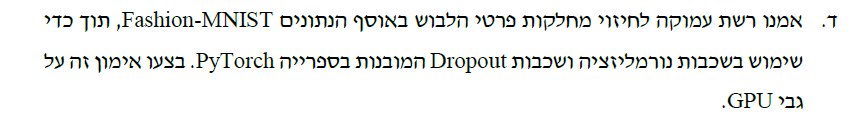



---



---



In [ ]:
import torchvision

trans=torchvision.transforms.Compose(
    [torchvision.transforms.PILToTensor(),
     torchvision.transforms.ConvertImageDtype(torch.float)])

train_data_transformed  = torchvision.datasets.FashionMNIST(
    root="/22961", train=True, download=True,
    transform=trans)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting /22961/FashionMNIST/raw/train-images-idx3-ubyte.gz to /22961/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting /22961/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /22961/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting /22961/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /22961/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting /22961/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /22961/FashionMNIST/raw



In [ ]:
def set_gpu_if_available():
    if torch.cuda.is_available():
      device = torch.device('cuda:0')
    else:
      device = torch.device('cpu')
    print(device)

In [ ]:
set_gpu_if_available()

cuda:0


## **PyTorch Model**

I will use a "Deep Network" inspired by the example we saw in class: 
***22961_2_2_4_single_layer_training_pytorch.ipynb***

In [ ]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784,100),
    nn.ReLU(),
    nn.Dropout(),
    nn.LayerNorm(100),
    nn.Linear(100,10),
    # nn.ReLU(),
    # nn.Linear(10,10),
    # nn.ReLU(),
    # nn.Linear(10,10), 
    nn.LogSoftmax(dim=1) 
).to(device)

print(model)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=100, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.5, inplace=False)
  (4): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
  (5): Linear(in_features=100, out_features=10, bias=True)
  (6): LogSoftmax(dim=1)
)


# **PyTorch Train**

In [ ]:
CE_loss=nn.NLLLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data_transformed, batch_size=256, shuffle=True)

# train_dataloader = DataLoader(train_data_transformed, batch_size=512,num_workers=1,shuffle=True,pin_memory=True)
len(train_dataloader) #num of batches in epoch

235

In [ ]:
def iterate_batch(imgs, labels, model_in, optimizer_in):
  # imgs, labels = next(iter(train_dataloader))
  # imgs = imgs.flatten(start_dim=1)

  imgs = imgs.to(device)
  labels=labels.to(device)
  
  optimizer_in.zero_grad()
  y_model=model_in(imgs)
  
  loss=CE_loss(y_model,labels)
  loss.backward()
  optimizer_in.step()
  
  predicted_labels = y_model.argmax(dim=1)
  acc = (predicted_labels == labels).sum()/len(labels)
  return loss.detach(), acc.detach()

In [ ]:
from tqdm import tqdm

batches=len(train_dataloader)
batch_loss=torch.zeros(batches)
batch_acc=torch.zeros(batches)
for idx, (imgs, labels) in tqdm(enumerate(train_dataloader)):
    batch_loss[idx], batch_acc[idx] = iterate_batch(imgs, labels, model, optimizer)

235it [00:11, 20.87it/s]


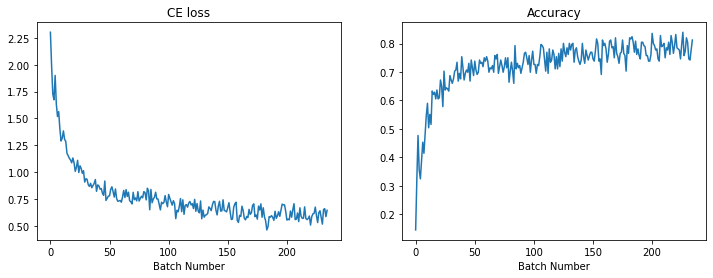

In [ ]:
from matplotlib import pyplot as plt

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(range(batches),batch_loss);
plt.title("CE loss");
plt.xlabel("Batch Number");
plt.subplot(1,2,2)
plt.plot(range(batches),batch_acc);
plt.title("Accuracy");
plt.xlabel("Batch Number");

## **Test**

In [ ]:
set_cpu()

cpu


In [ ]:
test_data_transformed = torchvision.datasets.FashionMNIST(root="/22961", train=False, download=True,transform=trans)
len(test_data_transformed)

test_dataloader = DataLoader(test_data_transformed, batch_size=256)
# train_dataloader = DataLoader(test_data_transformed, batch_size=256,num_workers=1,shuffle=True,pin_memory=True)


In [ ]:
def eval_model_test(model_in):
  model_in.to(device)
  loss=0.
  acc=0.
  test_batches=len(test_dataloader)
  for imgs, labels in test_dataloader:
    imgs = imgs.flatten(start_dim=1).to(device)
    with torch.no_grad():
      y_model=model_in(imgs) 
      loss += CE_loss(y_model,labels)
      predicted_labels = y_model.argmax(dim=1)
      acc += (predicted_labels == labels).sum()/len(labels)
  return loss/test_batches, acc/test_batches

In [ ]:
eval_model_test(model)

(tensor(0.6546), tensor(0.7665))



---

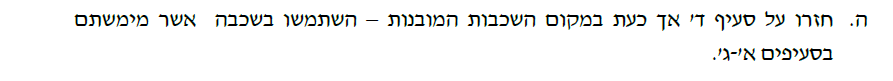

---



In [ ]:
set_gpu_if_available()

cuda:0


# **My (first) Model**

In [ ]:
my_model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784,100),
    nn.ReLU(),
    DropNorm(100),
    nn.Linear(100,10),
    # nn.ReLU(),
    # nn.Linear(10,10),
    # nn.ReLU(),
    # nn.Linear(10,10), 
    nn.LogSoftmax(dim=1) 
).to(device)

print(my_model)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=100, bias=True)
  (2): ReLU()
  (3): DropNorm()
  (4): Linear(in_features=100, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)


# **My Model Train**

In [ ]:
my_optimizer = torch.optim.SGD(my_model.parameters(), lr=0.1)

In [ ]:
from tqdm import tqdm

my_batches=len(train_dataloader)
my_batch_loss=torch.zeros(my_batches)
my_batch_loss.to(device)

my_batch_acc=torch.zeros(my_batches)
my_batch_acc.to(device)
for idx, (imgs, labels) in tqdm(enumerate(train_dataloader)):
  my_batch_loss[idx], my_batch_acc[idx] = iterate_batch(imgs, labels, my_model, my_optimizer)

4it [00:00, 18.30it/s]

After Dropout:
tensor([[0.0000, 0.3334, 0.0000,  ..., 0.0000, 0.1694, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0371, 0.0000, 0.0000],
        [0.0000, 0.0242, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0505, 0.0000,  ..., 0.1624, 0.2890, 0.0000],
        [0.0000, 0.0998, 0.0000,  ..., 0.0000, 0.3981, 0.0000],
        [0.0040, 0.0000, 0.0000,  ..., 0.1201, 0.0937, 0.0000]],
       grad_fn=<MulBackward0>)
Non Zero:
tensor([[0.0000, 0.0206, 0.3782,  ..., 0.0000, 0.1274, 0.0000],
        [0.0000, 0.0000, 0.4135,  ..., 0.0000, 0.0166, 0.0068],
        [0.0000, 0.0464, 0.2736,  ..., 0.0135, 0.0143, 0.0000],
        ...,
        [0.0000, 0.0000, 0.5237,  ..., 0.0000, 0.0000, 0.0000],
        [0.0198, 0.0000, 0.3299,  ..., 0.0000, 0.2177, 0.2410],
        [0.0000, 0.0000, 0.2075,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<IndexBackward0>)


DropNorm forward res:
tensor([[ 0.0000,  1.2094,  0.0000,  ...,  0.0000,  0.2782,  0.0000],
        [ 0.0000,  0.

8it [00:00, 18.53it/s]

After Dropout:
tensor([[0.6593, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.4934, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.6858, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<MulBackward0>)
Non Zero:
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.6593, 0.3231],
        [0.1353, 0.0000, 0.0568,  ..., 0.0000, 0.0000, 0.0493],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.4934, 0.0000],
        ...,
        [0.0000, 0.0425, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.1025, 0.0000, 0.0000,  ..., 0.0000, 0.6858, 0.1162],
        [0.0946, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0168]],
       grad_fn=<IndexBackward0>)


DropNorm forward res:
tensor([[2.6554, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.

12it [00:00, 18.83it/s]

After Dropout:
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.1916, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0027, 0.3245],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.4909, 0.5187],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.2480, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.5103],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.3611, 0.0000]],
       grad_fn=<MulBackward0>)
Non Zero:
tensor([[0.2260, 0.0000, 0.0447,  ..., 0.0000, 0.0000, 0.0000],
        [0.0330, 0.0000, 0.4464,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.4255,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.1292, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0099, 0.0000, 0.6717,  ..., 0.0266, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<IndexBackward0>)


DropNorm forward res:
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.6155,  0.0000],
        [ 0.0000,  0.

16it [00:00, 18.78it/s]

After Dropout:
tensor([[0.0000, 0.0000, 0.5540,  ..., 0.0000, 0.2605, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.9559, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.8391, 0.0000],
        ...,
        [0.0000, 0.0000, 0.5757,  ..., 0.0000, 0.0680, 0.0000],
        [0.0000, 0.0000, 0.4620,  ..., 0.0000, 0.0066, 0.0000],
        [0.0000, 0.0000, 0.2936,  ..., 0.0000, 0.1326, 0.0000]],
       grad_fn=<MulBackward0>)
Non Zero:
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.3226, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0511, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<IndexBackward0>)


DropNorm forward res:
tensor([[ 0.0000,  0.0000,  1.4990,  ...,  0.0000,  0.3992,  0.0000],
        [ 0.0000,  0.

20it [00:01, 18.48it/s]

After Dropout:
tensor([[0.3882, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.3603,  ..., 0.0000, 0.0000, 0.0000],
        [1.2223, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0822],
        ...,
        [0.0000, 0.0000, 0.4504,  ..., 0.0000, 0.0000, 0.0000],
        [0.1971, 0.0000, 0.2178,  ..., 0.0000, 0.0000, 0.3518],
        [0.3785, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<MulBackward0>)
Non Zero:
tensor([[0.0000, 0.4502, 0.0000,  ..., 0.0000, 0.1607, 0.0156],
        [0.0000, 0.0000, 0.0000,  ..., 0.2848, 0.0000, 0.0000],
        [0.0000, 0.6052, 0.2209,  ..., 0.0000, 0.6890, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1600, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.3870, 0.0000],
        [0.0000, 0.3081, 0.0000,  ..., 0.0000, 0.5565, 0.0000]],
       grad_fn=<IndexBackward0>)


DropNorm forward res:
tensor([[ 1.4130,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.

24it [00:01, 18.84it/s]

After Dropout:
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0523, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.0591, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0516, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.6565, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.4363, 0.0000]],
       grad_fn=<MulBackward0>)
Non Zero:
tensor([[0.4548, 0.0000, 0.0000,  ..., 0.6997, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0045,  ..., 0.0000, 0.0000, 0.0000],
        [0.4076, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.6252, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0242, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<IndexBackward0>)


DropNorm forward res:
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000, -0.2206,  0.0000],
        [ 0.0000,  0.

28it [00:01, 18.70it/s]

After Dropout:
tensor([[0.0000, 0.0000, 1.1169,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.0656,  ..., 0.0000, 0.0000, 0.0000],
        [0.1552, 0.0000, 0.3535,  ..., 0.0532, 0.0000, 0.0000],
        ...,
        [1.1112, 0.0000, 0.6034,  ..., 0.8640, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.2127,  ..., 0.0000, 0.0000, 0.0000],
        [0.2540, 0.0000, 0.6328,  ..., 0.1855, 0.0000, 0.0000]],
       grad_fn=<MulBackward0>)
Non Zero:
tensor([[0.0000, 0.4211, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.2540, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.1859, 0.0000, 0.0000],
        ...,
        [0.0000, 0.4417, 0.0000,  ..., 1.2576, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0402, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.1474, 0.0000, 0.0000]],
       grad_fn=<IndexBackward0>)


DropNorm forward res:
tensor([[ 0.0000,  0.0000,  3.6704,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.

32it [00:01, 18.87it/s]

After Dropout:
tensor([[0.3895, 0.0000, 0.0000,  ..., 0.7377, 0.0039, 0.0000],
        [1.5018, 0.0000, 0.0000,  ..., 1.0088, 0.4711, 0.1410],
        [0.6281, 0.0000, 0.0000,  ..., 0.0000, 0.2137, 0.0210],
        ...,
        [0.1048, 0.0000, 0.6645,  ..., 0.0000, 0.1801, 0.8429],
        [0.0000, 0.0000, 0.0975,  ..., 0.1343, 0.0000, 0.0000],
        [0.1997, 0.0000, 0.1652,  ..., 0.7924, 0.1839, 0.0000]],
       grad_fn=<MulBackward0>)
Non Zero:
tensor([[0.3388, 0.0000, 0.2627,  ..., 0.0687, 0.3355, 0.0000],
        [0.4647, 0.0000, 0.6387,  ..., 0.2384, 0.1144, 0.0000],
        [0.0000, 0.0668, 0.0000,  ..., 0.0237, 0.0000, 0.0000],
        ...,
        [0.1115, 0.4662, 0.3423,  ..., 0.0797, 0.0000, 0.8442],
        [0.4883, 0.0000, 0.0000,  ..., 0.0000, 1.0183, 0.0000],
        [0.6995, 0.0000, 0.1146,  ..., 0.0806, 0.3208, 0.0000]],
       grad_fn=<IndexBackward0>)


DropNorm forward res:
tensor([[ 1.3999,  0.0000,  0.0000,  ...,  3.1960, -0.5892,  0.0000],
        [ 3.2986,  0.

36it [00:01, 18.68it/s]

After Dropout:
tensor([[0.7769, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.5674],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.2075],
        ...,
        [0.4266, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0102, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.3129, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<MulBackward0>)
Non Zero:
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.8248, 0.0000, 0.4740],
        [0.0000, 0.0621, 0.0000,  ..., 0.0000, 0.1205, 0.2264],
        [0.0000, 0.1693, 0.0000,  ..., 0.0000, 0.0670, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.7152, 0.1662, 0.0366],
        [0.0000, 0.1996, 0.0000,  ..., 0.0295, 0.2261, 0.0312],
        [0.0000, 0.0300, 0.0000,  ..., 0.3405, 0.1262, 0.2589]],
       grad_fn=<IndexBackward0>)


DropNorm forward res:
tensor([[ 1.7145,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.

40it [00:02, 18.29it/s]

After Dropout:
tensor([[0.0000, 0.0000, 1.0556,  ..., 0.0000, 0.0000, 0.6135],
        [0.4084, 0.0000, 0.2576,  ..., 0.0000, 0.0000, 0.1396],
        [0.1334, 0.0000, 0.5674,  ..., 0.0000, 0.0000, 0.4546],
        ...,
        [0.0000, 0.0000, 0.6697,  ..., 0.0000, 0.0000, 0.0000],
        [0.5692, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<MulBackward0>)
Non Zero:
tensor([[0.0000, 1.6654, 0.0000,  ..., 0.0000, 0.0000, 0.0113],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.5800, 0.0643],
        [0.0000, 0.8811, 0.0000,  ..., 0.0000, 0.0000, 0.0746],
        ...,
        [0.3030, 0.0000, 0.0000,  ..., 0.6387, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.2744, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.7112, 0.4773]],
       grad_fn=<IndexBackward0>)


DropNorm forward res:
tensor([[ 0.0000,  0.0000,  2.1717,  ...,  0.0000,  0.0000,  1.0600],
        [ 0.8078,  0.

44it [00:02, 18.58it/s]

After Dropout:
tensor([[1.7976, 0.0000, 0.0000,  ..., 1.0589, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.1967, 0.0000, 0.0000],
        [1.1605, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.6170],
        ...,
        [2.2044, 0.0000, 0.0000,  ..., 0.0387, 0.0000, 0.3493],
        [1.8093, 0.0000, 0.0000,  ..., 1.8632, 0.0000, 0.0000],
        [1.3853, 0.0000, 0.0000,  ..., 1.2548, 0.0000, 0.0000]],
       grad_fn=<MulBackward0>)
Non Zero:
tensor([[0.0480, 0.0000, 1.7976,  ..., 0.0000, 1.0589, 0.9879],
        [0.3302, 0.0000, 0.0000,  ..., 0.0000, 0.1967, 0.0329],
        [0.5501, 0.0000, 1.1605,  ..., 0.6303, 0.0000, 0.7214],
        ...,
        [0.2080, 0.0000, 2.2044,  ..., 0.6747, 0.0387, 0.6984],
        [0.0000, 0.0000, 1.8093,  ..., 0.0000, 1.8632, 1.6634],
        [0.0539, 0.0000, 1.3853,  ..., 0.0000, 1.2548, 1.2645]],
       grad_fn=<IndexBackward0>)


DropNorm forward res:
tensor([[ 3.3422,  0.0000,  0.0000,  ...,  1.7405,  0.0000,  0.0000],
        [ 0.0000,  0.

48it [00:02, 18.39it/s]

After Dropout:
tensor([[0.0000, 0.0000, 0.3492,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.4191, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0885,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.5632, 0.0000],
        [0.0000, 0.0000, 0.5165,  ..., 0.0000, 0.0125, 0.0000]],
       grad_fn=<MulBackward0>)
Non Zero:
tensor([[0.0000, 0.4645, 0.0000,  ..., 0.0000, 0.3492, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0345, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0885, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.4841, 0.0000,  ..., 0.0000, 0.5165, 0.0000]],
       grad_fn=<IndexBackward0>)


DropNorm forward res:
tensor([[ 0.0000,  0.0000,  1.5017,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.

52it [00:02, 18.70it/s]

After Dropout:
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.9125, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.1495, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0359, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.2606, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.0523, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.3849, 0.2993]],
       grad_fn=<MulBackward0>)
Non Zero:
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.3217, 0.9125],
        [0.0000, 0.2146, 0.0000,  ..., 0.0000, 0.0000, 0.1495],
        [0.1791, 1.5030, 0.0101,  ..., 0.0000, 0.1395, 0.0359],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.2014, 0.2606],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.6999, 1.0523],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.3804, 0.3849]],
       grad_fn=<IndexBackward0>)


DropNorm forward res:
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  2.2693,  0.0000],
        [ 0.0000,  0.

56it [00:03, 18.56it/s]

After Dropout:
tensor([[0.7191, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0395,  ..., 0.0000, 0.0000, 0.0000],
        [0.4780, 0.0000, 0.0000,  ..., 0.0000, 0.1459, 0.0699],
        ...,
        [0.1776, 0.0000, 0.3917,  ..., 0.0000, 0.0000, 0.2874],
        [0.9812, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<MulBackward0>)
Non Zero:
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.1710],
        [0.0395, 0.0000, 0.0000,  ..., 0.2764, 0.0000, 0.0286],
        [0.0000, 0.5586, 0.0000,  ..., 0.0000, 0.0077, 0.1464],
        ...,
        [0.3917, 0.7509, 0.0000,  ..., 0.0000, 0.0000, 0.1971],
        [0.0000, 0.0037, 0.0000,  ..., 0.0000, 0.0000, 0.0727],
        [0.0000, 0.0000, 0.2234,  ..., 0.4685, 0.2448, 0.0000]],
       grad_fn=<IndexBackward0>)


DropNorm forward res:
tensor([[ 3.6806,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.

60it [00:03, 18.20it/s]

After Dropout:
tensor([[0.6004, 0.0000, 0.0000,  ..., 0.0000, 0.0337, 0.0000],
        [1.2760, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [1.1809, 0.0000, 0.0000,  ..., 0.0000, 0.5611, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.5957, 0.0000, 0.0000,  ..., 0.0000, 0.0243, 0.0000]],
       grad_fn=<MulBackward0>)
Non Zero:
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0956, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.3406, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.7084, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<IndexBackward0>)


DropNorm forward res:
tensor([[ 3.1349,  0.0000,  0.0000,  ...,  0.0000, -0.2540,  0.0000],
        [ 4.3835,  0.

64it [00:03, 18.37it/s]

After Dropout:
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.2659, 0.1057],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.5720, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.5520, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.9900, 0.0549]],
       grad_fn=<MulBackward0>)
Non Zero:
tensor([[0.4575, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.6461, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.1164],
        [0.0000, 0.4384, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.2881, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 1.2172, 0.0000, 0.3861],
        [0.6947, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.5818]],
       grad_fn=<IndexBackward0>)


DropNorm forward res:
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  2.3241,  0.6520],
        [ 0.0000,  0.

68it [00:03, 18.22it/s]

After Dropout:
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0465],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.8911,  ..., 0.0000, 0.0000, 0.7618],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0820]],
       grad_fn=<MulBackward0>)
Non Zero:
tensor([[0.0000, 0.2135, 0.0000,  ..., 0.0000, 1.5280, 0.0000],
        [0.0000, 0.3659, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0465, 0.0000, 0.0216,  ..., 0.0000, 1.6925, 0.0000],
        ...,
        [0.0000, 0.0420, 0.0000,  ..., 0.0000, 0.0283, 0.0000],
        [0.7618, 0.0000, 1.4700,  ..., 0.0000, 0.0308, 1.4260],
        [0.0820, 0.2685, 0.0000,  ..., 0.0000, 0.0975, 0.0000]],
       grad_fn=<IndexBackward0>)


DropNorm forward res:
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.

72it [00:03, 18.26it/s]

After Dropout:
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.7955, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<MulBackward0>)
Non Zero:
tensor([[0.0000, 0.0926, 0.2763,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.5645, 0.0000, 0.6390],
        [0.0000, 0.5836, 0.1356,  ..., 0.2022, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0274, 0.0000,  ..., 0.5884, 0.0000, 0.5134],
        [0.0000, 0.0000, 0.0000,  ..., 0.1372, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.5195,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<IndexBackward0>)


DropNorm forward res:
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.9594, 0.0000],
        [0.0000, 0.0000, 0.

76it [00:04, 17.71it/s]

After Dropout:
tensor([[1.7034, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [1.6781, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [1.3914, 0.0000, 0.0000,  ..., 0.0000, 0.1104, 0.0000],
        [0.0846, 0.0000, 0.0000,  ..., 0.0000, 0.0705, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<MulBackward0>)
Non Zero:
tensor([[1.1888, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [1.2134, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.6169, 0.0000, 0.1802,  ..., 0.0000, 0.1964, 0.0000],
        ...,
        [1.1585, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [1.4102, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0596],
        [0.3475, 0.6804, 0.3182,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<IndexBackward0>)


DropNorm forward res:
tensor([[ 3.6559,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 3.5324,  0.

80it [00:04, 18.27it/s]

After Dropout:
tensor([[1.0132, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.1655],
        [1.0911, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.2956],
        [1.4173, 0.0000, 0.0000,  ..., 0.0000, 0.4515, 0.0000],
        ...,
        [0.0416, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.2429],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [1.0928, 0.0000, 0.0000,  ..., 0.0000, 0.1179, 0.0000]],
       grad_fn=<MulBackward0>)
Non Zero:
tensor([[0.8772, 0.2052, 0.0000,  ..., 0.0000, 0.5518, 0.5270],
        [0.4504, 0.4085, 0.0000,  ..., 0.0524, 0.0000, 1.3869],
        [1.9564, 1.6046, 0.0000,  ..., 0.4048, 0.2703, 0.7694],
        ...,
        [0.0000, 1.0433, 0.2024,  ..., 0.0000, 0.0000, 0.0343],
        [0.0000, 0.0000, 0.2189,  ..., 0.0000, 0.0000, 0.0000],
        [1.0585, 0.6012, 0.0000,  ..., 0.2817, 0.3623, 1.1855]],
       grad_fn=<IndexBackward0>)


DropNorm forward res:
tensor([[ 2.7375,  0.0000,  0.0000,  ...,  0.0000,  0.0000, -0.0033],
        [ 2.6206,  0.

84it [00:04, 18.44it/s]

After Dropout:
tensor([[0.0000, 0.0000, 0.1219,  ..., 0.0000, 0.0000, 0.0000],
        [1.2379, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.1813, 0.0000, 0.2558,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.8438,  ..., 0.0000, 0.0000, 0.0000],
        [1.6812, 0.0000, 0.0000,  ..., 0.0000, 0.4797, 0.0000]],
       grad_fn=<MulBackward0>)
Non Zero:
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.1666, 0.1063, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.1452, 0.6082, 0.0000],
        ...,
        [0.2448, 0.0000, 0.0000,  ..., 0.5143, 0.0000, 0.0000],
        [1.8061, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.3609, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<IndexBackward0>)


DropNorm forward res:
tensor([[0.0000, 0.0000, 1.0288,  ..., 0.0000, 0.0000, 0.0000],
        [3.2672, 0.0000, 0.

88it [00:04, 18.52it/s]

After Dropout:
tensor([[0.0000, 0.0000, 0.1825,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0456,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.1134, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.3421, 0.0000, 0.0713,  ..., 0.0000, 0.0000, 0.0000],
        [0.5551, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<MulBackward0>)
Non Zero:
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.3060, 0.5564, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.4331, 0.1043, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.3641, 0.9660, 0.0000],
        ...,
        [0.1134, 0.0000, 0.0000,  ..., 0.1574, 0.1451, 0.0000],
        [0.3421, 0.0000, 0.0000,  ..., 0.0000, 0.3497, 0.0000],
        [0.5551, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<IndexBackward0>)


DropNorm forward res:
tensor([[ 0.0000,  0.0000,  0.2528,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.

92it [00:04, 18.43it/s]

After Dropout:
tensor([[0.0000, 0.0000, 0.1071,  ..., 0.0000, 0.0000, 0.0000],
        [0.4898, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2222, 0.0000, 0.0000,  ..., 0.0000, 0.0323, 0.0000],
        ...,
        [0.0000, 0.0000, 0.4694,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.8072, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<MulBackward0>)
Non Zero:
tensor([[0.0390, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.4073, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.4195, 0.3502, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.2892, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.4472],
        [0.0000, 0.1465, 0.1007,  ..., 0.0000, 0.3071, 0.0107],
        [0.8988, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0097]],
       grad_fn=<IndexBackward0>)


DropNorm forward res:
tensor([[ 0.0000,  0.0000,  0.0447,  ...,  0.0000,  0.0000,  0.0000],
        [ 3.0914,  0.

96it [00:05, 18.24it/s]

After Dropout:
tensor([[0.2318, 0.0000, 0.0000,  ..., 0.0000, 0.2318, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.1527, 0.5324],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<MulBackward0>)
Non Zero:
tensor([[0.3314, 0.0000, 0.0000,  ..., 0.0224, 0.2318, 0.0871],
        [0.0000, 0.0000, 0.0000,  ..., 0.0684, 0.1527, 0.0737],
        [0.0000, 0.4214, 0.0000,  ..., 0.1267, 0.0000, 0.0000],
        ...,
        [0.0000, 0.2651, 0.1263,  ..., 0.4538, 0.0000, 0.0000],
        [0.0000, 0.4436, 0.0000,  ..., 0.1342, 0.0000, 0.0000],
        [0.0000, 0.2371, 0.0000,  ..., 0.3167, 0.0000, 0.0000]],
       grad_fn=<IndexBackward0>)


DropNorm forward res:
tensor([[2.4721, 0.0000, 0.0000,  ..., 0.0000, 2.4718, 0.0000],
        [0.0000, 0.0000, 0.

100it [00:05, 18.53it/s]

After Dropout:
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.8236, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.2571, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.5678,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<MulBackward0>)
Non Zero:
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 2.2414, 0.0237],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 2.1653, 0.0000],
        [0.0000, 0.5486, 0.0000,  ..., 0.0000, 0.0000, 0.5091],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.0724, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.6966, 0.0000],
        [0.0000, 0.4294, 0.0000,  ..., 0.8256, 0.0205, 0.0000]],
       grad_fn=<IndexBackward0>)


DropNorm forward res:
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.

104it [00:05, 18.40it/s]

After Dropout:
tensor([[1.4267, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.6620,  ..., 0.0000, 0.0000, 0.0000],
        [1.0386, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [1.3022, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.7423, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.6533, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<MulBackward0>)
Non Zero:
tensor([[0.0000, 0.0000, 0.2964,  ..., 0.4472, 0.0000, 1.4267],
        [0.7126, 0.0000, 0.0000,  ..., 0.0000, 0.8328, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.0386],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.3022],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.7423],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.6533]],
       grad_fn=<IndexBackward0>)


DropNorm forward res:
tensor([[3.5932, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 2.

108it [00:05, 18.14it/s]

After Dropout:
tensor([[1.2212, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.8780, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [1.8673, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<MulBackward0>)
Non Zero:
tensor([[0.0000, 0.5621, 0.7737,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0848, 0.0051,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0579, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.6597, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<IndexBackward0>)


DropNorm forward res:
tensor([[3.1372, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.

112it [00:06, 18.22it/s]

After Dropout:
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0138],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.1892]],
       grad_fn=<MulBackward0>)
Non Zero:
tensor([[2.0379, 0.6658, 0.0000,  ..., 0.0000, 0.0429, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.7078, 2.2349],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.5459],
        ...,
        [0.7085, 0.1981, 0.0000,  ..., 0.0000, 0.3955, 0.1853],
        [1.6849, 0.4951, 0.0000,  ..., 0.0000, 0.0869, 0.2490],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.1227]],
       grad_fn=<IndexBackward0>)


DropNorm forward res:
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.

116it [00:06, 18.02it/s]

After Dropout:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], grad_fn=<MulBackward0>)
Non Zero:
tensor([[0.5054, 0.0000, 0.3235,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0389, 0.9726, 0.0000],
        [0.4568, 0.0000, 0.0000,  ..., 0.1091, 0.3596, 0.0000],
        ...,
        [0.5420, 0.0000, 0.0000,  ..., 0.0673, 0.2851, 0.0000],
        [1.6552, 0.0000, 0.6181,  ..., 0.0000, 0.9253, 0.0000],
        [0.8158, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<IndexBackward0>)


DropNorm forward res:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0.

120it [00:06, 17.60it/s]

After Dropout:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], grad_fn=<MulBackward0>)
Non Zero:
tensor([[0.0000, 1.0917, 0.3430,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.3043, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.8406, 0.2918,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.4637, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<IndexBackward0>)


DropNorm forward res:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0.

124it [00:07, 11.22it/s]

After Dropout:
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.7138],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<MulBackward0>)
Non Zero:
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.5104, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.3706, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.1956, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.0590, 0.0000]],
       grad_fn=<IndexBackward0>)


DropNorm forward res:
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.

128it [00:07, 13.80it/s]

After Dropout:
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.6111],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.6607],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<MulBackward0>)
Non Zero:
tensor([[0.2212, 0.0000, 0.0066,  ..., 0.1010, 0.0000, 0.4374],
        [0.0000, 0.0000, 0.0000,  ..., 0.0866, 0.0000, 0.0000],
        [0.7716, 0.0000, 0.0000,  ..., 0.1265, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.3270, 0.0000, 0.2693],
        [0.0000, 0.2082, 0.0000,  ..., 0.4715, 0.0000, 0.0000],
        [0.0000, 0.1454, 0.0000,  ..., 0.5959, 0.0000, 0.0000]],
       grad_fn=<IndexBackward0>)


DropNorm forward res:
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 2.3960],
        [0.0000, 0.0000, 0.

132it [00:07, 15.63it/s]

After Dropout:
tensor([[0.0000, 0.0000, 0.9653,  ..., 0.0000, 0.0000, 0.0000],
        [0.0754, 0.0000, 1.2379,  ..., 0.0000, 0.0000, 0.0000],
        [1.0233, 0.0000, 0.5086,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 1.0518,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.2042,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<MulBackward0>)
Non Zero:
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.1496, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.4684, 0.0000, 0.0000],
        [0.1450, 0.0000, 0.0000,  ..., 0.0546, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0144, 0.0000, 0.0000],
        [0.0000, 0.0155, 0.0000,  ..., 0.0000, 0.2161, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.1422, 0.0000]],
       grad_fn=<IndexBackward0>)


DropNorm forward res:
tensor([[ 0.0000,  0.0000,  2.9815,  ...,  0.0000,  0.0000,  0.0000],
        [-0.1857,  0.

136it [00:07, 16.49it/s]

After Dropout:
tensor([[0.0000, 0.0000, 0.4131,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.4879,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.2016,  ..., 0.0000, 0.3374, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.4364,  ..., 0.0000, 0.3900, 0.0000]],
       grad_fn=<MulBackward0>)
Non Zero:
tensor([[0.0000, 0.0000, 0.0446,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0061,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.6259, 0.2083, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0868,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.2036, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.8728, 0.0000, 0.0000]],
       grad_fn=<IndexBackward0>)


DropNorm forward res:
tensor([[ 0.0000,  0.0000,  1.7024,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.

140it [00:07, 16.79it/s]

After Dropout:
tensor([[0.0000, 0.0000, 1.0757,  ..., 0.0000, 0.0000, 0.0000],
        [0.9142, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2817, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.5865, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.1401, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0021, 0.0000, 0.3373,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<MulBackward0>)
Non Zero:
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4620],
        [0.0000, 0.1360, 0.1528,  ..., 0.0000, 0.3673, 0.1136],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0191],
        ...,
        [0.0000, 0.0000, 0.0972,  ..., 0.0000, 0.1037, 0.1719],
        [0.0000, 0.3088, 0.1020,  ..., 0.0561, 0.4153, 0.2204],
        [0.0000, 0.0094, 0.0000,  ..., 0.0000, 0.0000, 0.3569]],
       grad_fn=<IndexBackward0>)


DropNorm forward res:
tensor([[ 0.0000,  0.0000,  2.5504,  ...,  0.0000,  0.0000,  0.0000],
        [ 1.3696,  0.

144it [00:08, 17.03it/s]

After Dropout:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], grad_fn=<MulBackward0>)
Non Zero:
tensor([[0.0000, 0.9312, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.1830, 0.0000, 0.0000],
        [0.0000, 0.1203, 0.0000,  ..., 0.1867, 0.0000, 0.0000],
        ...,
        [1.1721, 0.0000, 0.4683,  ..., 0.0000, 1.3379, 0.0000],
        [0.0000, 0.0000, 0.1687,  ..., 0.0000, 0.7560, 0.0000],
        [0.0000, 0.0000, 0.0492,  ..., 0.0000, 0.0511, 0.0000]],
       grad_fn=<IndexBackward0>)


DropNorm forward res:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0.

148it [00:08, 17.75it/s]

After Dropout:
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.1934,  ..., 0.0000, 0.0000, 0.7055],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0875, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<MulBackward0>)
Non Zero:
tensor([[0.0000, 0.0000, 0.0000,  ..., 1.3407, 1.6586, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.5545],
        [0.0221, 0.1146, 0.0000,  ..., 0.5038, 0.3323, 0.0000],
        ...,
        [0.0000, 0.4648, 0.0000,  ..., 0.0810, 0.0000, 0.0000],
        [0.0000, 0.2958, 0.0000,  ..., 1.2156, 2.9505, 0.0000],
        [0.6749, 0.1411, 0.0000,  ..., 0.6273, 0.8921, 0.0000]],
       grad_fn=<IndexBackward0>)


DropNorm forward res:
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.

152it [00:08, 17.58it/s]

After Dropout:
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.3976, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.6189,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 1.0305,  ..., 0.0000, 0.0000, 0.0000],
        [0.9169, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<MulBackward0>)
Non Zero:
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.6904, 0.0000, 0.0000],
        [0.1972, 0.3976, 0.0000,  ..., 0.0000, 0.0000, 0.7080],
        [0.0000, 0.0000, 0.6740,  ..., 0.2572, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.9138],
        [0.0000, 0.9169, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0244, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<IndexBackward0>)


DropNorm forward res:
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [2.1521, 0.0000, 0.

156it [00:08, 17.28it/s]

After Dropout:
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.3060,  ..., 0.0000, 0.0000, 0.9042],
        [0.0000, 0.0000, 1.4539,  ..., 0.0000, 0.0000, 1.1804],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0657, 0.0000],
        [0.0000, 0.0000, 0.7722,  ..., 0.0000, 0.0000, 1.2759],
        [0.0000, 0.0000, 0.4279,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<MulBackward0>)
Non Zero:
tensor([[0.0000, 0.9050, 0.0000,  ..., 0.0000, 0.3942, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0022, 0.0000],
        [0.7102, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.6783, 0.0657,  ..., 0.0000, 0.9447, 0.0000],
        [0.1679, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.1427, 0.0000, 0.0000,  ..., 0.0000, 0.1774, 0.9150]],
       grad_fn=<IndexBackward0>)


DropNorm forward res:
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.

160it [00:09, 17.51it/s]

After Dropout:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], grad_fn=<MulBackward0>)
Non Zero:
tensor([[0.4794, 0.4636, 0.0000,  ..., 0.0000, 0.0577, 0.0000],
        [0.0000, 0.1381, 0.0000,  ..., 0.1766, 0.0000, 0.0000],
        [0.5252, 0.2680, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.9212, 0.7712, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0030, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0304, 0.0000,  ..., 0.5599, 0.0000, 0.4544]],
       grad_fn=<IndexBackward0>)


DropNorm forward res:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0.

164it [00:09, 17.94it/s]

After Dropout:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], grad_fn=<MulBackward0>)
Non Zero:
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0369, 0.0000, 0.0000],
        [0.4525, 0.0000, 0.0000,  ..., 0.0257, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0035, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.4150, 0.0000, 0.0000,  ..., 0.7616, 0.0000, 0.0000],
        [0.6901, 0.0000, 0.0000,  ..., 0.1334, 0.0000, 0.0000]],
       grad_fn=<IndexBackward0>)


DropNorm forward res:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0.

168it [00:09, 17.99it/s]

After Dropout:
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0716,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<MulBackward0>)
Non Zero:
tensor([[0.2214, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0778],
        [0.6926, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.1021,  ..., 0.0000, 0.0000, 0.0206],
        ...,
        [0.1470, 0.0000, 0.0000,  ..., 0.0716, 0.0000, 0.1508],
        [0.5936, 0.0365, 1.7541,  ..., 0.0000, 0.0000, 0.1364],
        [0.0000, 0.2246, 0.0000,  ..., 0.0000, 0.0000, 0.8017]],
       grad_fn=<IndexBackward0>)


DropNorm forward res:
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.

172it [00:09, 18.08it/s]

After Dropout:
tensor([[0.0000, 0.0000, 0.0735,  ..., 0.0000, 0.0133, 0.9143],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 3.3610, 0.0000],
        ...,
        [0.0000, 0.0000, 0.1084,  ..., 0.0000, 0.3127, 0.0000],
        [0.0000, 0.0000, 0.2428,  ..., 0.0000, 0.4067, 1.1033],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<MulBackward0>)
Non Zero:
tensor([[0.0133, 0.0490, 0.0000,  ..., 0.0000, 1.0825, 1.2826],
        [0.0000, 0.0000, 0.0000,  ..., 0.0072, 0.0704, 1.7687],
        [3.3610, 0.2395, 0.0000,  ..., 0.0000, 2.1684, 0.8634],
        ...,
        [0.3127, 0.0000, 0.0000,  ..., 0.0000, 0.6076, 1.0056],
        [0.4067, 0.0000, 0.0000,  ..., 0.1400, 1.6917, 1.1825],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.5843, 2.1000]],
       grad_fn=<IndexBackward0>)


DropNorm forward res:
tensor([[ 0.0000,  0.0000, -0.2561,  ...,  0.0000, -0.4442,  2.3735],
        [ 0.0000,  0.

176it [00:10, 18.15it/s]

After Dropout:
tensor([[0.8205, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0109],
        [0.4360, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.3086],
        [0.3995, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [1.1067, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.1738],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4842],
        [0.1609, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<MulBackward0>)
Non Zero:
tensor([[0.0000, 0.2512, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0253, 0.0833, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.3163, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.6486, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.3871, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.2486],
        [0.0000, 0.1299, 0.0000,  ..., 0.0000, 0.0000, 0.1559]],
       grad_fn=<IndexBackward0>)


DropNorm forward res:
tensor([[ 3.5349,  0.0000,  0.0000,  ...,  0.0000,  0.0000, -0.4522],
        [ 1.2872,  0.

180it [00:10, 17.45it/s]

After Dropout:
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.2597,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.5301,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.8379,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<MulBackward0>)
Non Zero:
tensor([[0.0177, 0.4012, 0.0000,  ..., 0.1388, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.4140,  ..., 0.0455, 0.5801, 0.8045],
        [0.0000, 0.0000, 0.6036,  ..., 0.0000, 0.2208, 0.7161],
        ...,
        [0.1094, 0.6816, 0.0000,  ..., 0.5203, 0.0359, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.6971],
        [0.0000, 0.2073, 0.0000,  ..., 1.9379, 1.8366, 0.0000]],
       grad_fn=<IndexBackward0>)


DropNorm forward res:
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.

184it [00:10, 17.44it/s]

After Dropout:
tensor([[0.0000, 0.0000, 0.0188,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.5478, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.7079, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0864, 0.1399,  ..., 0.0000, 0.0000, 0.0000],
        [0.5747, 0.0000, 0.0000,  ..., 0.0000, 0.4571, 0.0000]],
       grad_fn=<MulBackward0>)
Non Zero:
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0048, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 1.4781, 0.0000,  ..., 2.5103, 0.0000, 0.0000],
        ...,
        [0.0000, 1.2150, 0.0000,  ..., 3.4932, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.1897,  ..., 0.0000, 0.0000, 0.0000],
        [0.3992, 0.0000, 0.0000,  ..., 0.3683, 0.0000, 0.0000]],
       grad_fn=<IndexBackward0>)


DropNorm forward res:
tensor([[ 0.0000,  0.0000, -0.4584,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.

188it [00:10, 17.67it/s]

After Dropout:
tensor([[0.2464, 0.0000, 0.0000,  ..., 0.0000, 0.2277, 0.0000],
        [0.4787, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.6002, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<MulBackward0>)
Non Zero:
tensor([[0.2338, 0.7615, 0.0000,  ..., 0.2464, 0.0000, 0.0000],
        [0.5449, 0.0000, 0.0000,  ..., 0.4787, 0.0000, 0.0000],
        [0.5517, 0.0000, 0.0000,  ..., 0.6002, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<IndexBackward0>)


DropNorm forward res:
tensor([[0.5058, 0.0000, 0.0000,  ..., 0.0000, 0.4225, 0.0000],
        [0.5396, 0.0000, 0.

192it [00:10, 18.11it/s]

After Dropout:
tensor([[0.0000, 0.0000, 0.0279,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<MulBackward0>)
Non Zero:
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.5288, 0.2206, 0.1556],
        [0.0000, 0.0000, 0.2929,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0286, 0.6396],
        [0.0000, 0.0000, 0.0000,  ..., 0.3589, 0.0000, 0.9648],
        [0.0000, 0.0000, 0.3580,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<IndexBackward0>)


DropNorm forward res:
tensor([[ 0.0000,  0.0000, -0.3997,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.

196it [00:11, 18.32it/s]

After Dropout:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], grad_fn=<MulBackward0>)
Non Zero:
tensor([[0.0000, 0.4033, 0.0000,  ..., 0.3300, 0.0155, 0.0000],
        [0.0000, 0.9483, 0.0000,  ..., 0.0000, 0.4543, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.3973,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.5668,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<IndexBackward0>)


DropNorm forward res:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0.

200it [00:11, 18.07it/s]

After Dropout:
tensor([[0.3133, 0.0000, 0.0000,  ..., 0.0000, 0.3398, 0.0000],
        [0.2413, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.6973, 0.0000, 0.0000,  ..., 0.0000, 2.1539, 0.0000],
        ...,
        [0.5856, 0.0000, 0.0000,  ..., 0.0000, 0.4399, 0.0000],
        [0.4202, 0.0000, 0.0000,  ..., 0.0000, 0.4233, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.5923, 0.0000]],
       grad_fn=<MulBackward0>)
Non Zero:
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.3133, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.2413, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 1.5401, 0.6973, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.5856, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0153, 0.4202, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<IndexBackward0>)


DropNorm forward res:
tensor([[0.4776, 0.0000, 0.0000,  ..., 0.0000, 0.5461, 0.0000],
        [0.2918, 0.0000, 0.

204it [00:11, 18.39it/s]

After Dropout:
tensor([[0.0000, 0.0000, 1.0209,  ..., 0.0000, 0.0000, 0.3618],
        [0.6969, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.4090,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.9170, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.3137, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0808,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<MulBackward0>)
Non Zero:
tensor([[0.0000, 0.0000, 0.9150,  ..., 1.6841, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.6363,  ..., 0.0000, 0.6969, 0.0916],
        [0.0000, 0.1590, 0.2120,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.3249,  ..., 0.0000, 0.9170, 0.3037],
        [0.0000, 0.0000, 0.8516,  ..., 0.9186, 0.3137, 0.0000],
        [0.0000, 0.2011, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<IndexBackward0>)


DropNorm forward res:
tensor([[0.0000, 0.0000, 2.5314,  ..., 0.0000, 0.0000, 0.6782],
        [1.8971, 0.0000, 0.

208it [00:11, 18.03it/s]

After Dropout:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], grad_fn=<MulBackward0>)
Non Zero:
tensor([[0.1839, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.6006, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [1.3025, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [1.2284, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<IndexBackward0>)


DropNorm forward res:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0.

212it [00:12, 18.05it/s]

After Dropout:
tensor([[0.2919, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.2295],
        [0.9453, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.9084],
        ...,
        [0.7369, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4760],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<MulBackward0>)
Non Zero:
tensor([[0.0000, 0.0604, 0.0000,  ..., 0.0381, 0.0000, 0.1682],
        [0.0000, 0.3187, 0.0000,  ..., 0.0000, 0.5671, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.8684],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.2684],
        [0.1144, 1.3318, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<IndexBackward0>)


DropNorm forward res:
tensor([[1.3161, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.9233],
        [2.5001, 0.0000, 0.

216it [00:12, 17.14it/s]

After Dropout:
tensor([[1.4186, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [1.8434, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.5441, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.6279],
        [2.0837, 0.0000, 0.0000,  ..., 0.0000, 0.9252, 0.0000],
        [0.7275, 0.0000, 0.0000,  ..., 0.0000, 0.0323, 0.0000]],
       grad_fn=<MulBackward0>)
Non Zero:
tensor([[0.1924, 0.8145, 0.0000,  ..., 0.0000, 1.4186, 0.0000],
        [0.4331, 0.5723, 0.0000,  ..., 0.0000, 1.8434, 0.0000],
        [0.0326, 1.0449, 0.0000,  ..., 0.0000, 0.5441, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.4573, 0.0000, 0.0000,  ..., 0.0000, 2.0837, 0.0000],
        [0.4167, 0.4694, 0.0000,  ..., 0.1105, 0.7275, 0.0000]],
       grad_fn=<IndexBackward0>)


DropNorm forward res:
tensor([[ 2.3591,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 3.3903,  0.

220it [00:12, 17.08it/s]

After Dropout:
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.7407, 0.0650],
        ...,
        [1.1902, 0.0000, 0.0000,  ..., 0.0000, 1.6382, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.9505, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<MulBackward0>)
Non Zero:
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.2691, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.4046, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.5189, 0.4902,  ..., 0.6262, 0.0000, 0.2384],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<IndexBackward0>)


DropNorm forward res:
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.

224it [00:12, 17.48it/s]

After Dropout:
tensor([[0.0000, 0.0000, 0.7745,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0262, 0.0000],
        [0.0000, 0.0000, 0.2049,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<MulBackward0>)
Non Zero:
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 2.0004, 0.0000],
        [0.4185, 0.0880, 0.0000,  ..., 0.0000, 0.1906, 0.0000],
        [0.6574, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.1969, 1.0517, 2.2547,  ..., 0.0868, 0.0000, 0.0000],
        [1.7614, 0.9397, 0.6702,  ..., 0.6593, 0.0000, 0.0000],
        [0.6975, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<IndexBackward0>)


DropNorm forward res:
tensor([[ 0.0000,  0.0000,  1.0667,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.

228it [00:12, 17.96it/s]

After Dropout:
tensor([[0.0107, 0.0000, 0.2194,  ..., 0.0000, 0.0000, 0.9197],
        [0.2042, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.8181, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.1973,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.0618,  ..., 0.0000, 0.0000, 0.7058],
        [0.0000, 0.0000, 0.2112,  ..., 0.0000, 0.0000, 0.8648]],
       grad_fn=<MulBackward0>)
Non Zero:
tensor([[0.0000, 0.0107, 0.0000,  ..., 0.0000, 0.0000, 0.7736],
        [0.0000, 0.2042, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.8181, 0.0000,  ..., 0.0000, 0.0000, 0.6257],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.5193, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.6898],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.5093]],
       grad_fn=<IndexBackward0>)


DropNorm forward res:
tensor([[-0.4135,  0.0000,  0.2053,  ...,  0.0000,  0.0000,  2.2826],
        [ 0.0797,  0.

232it [00:13, 18.05it/s]

After Dropout:
tensor([[0.8251, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.6703,  ..., 0.0000, 0.0000, 0.0000],
        [0.3895, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.5278,  ..., 0.0000, 0.0000, 0.0000],
        [1.1498, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.6772, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<MulBackward0>)
Non Zero:
tensor([[0.4102, 0.0000, 0.3331,  ..., 0.0000, 0.7255, 0.0000],
        [0.0000, 0.0000, 0.0360,  ..., 0.0000, 0.0000, 0.0000],
        [0.9104, 0.0000, 0.6604,  ..., 0.0000, 0.2506, 1.7359],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.5440,  ..., 0.0000, 1.4700, 0.3096],
        [0.0000, 0.0000, 0.2129,  ..., 0.0000, 0.6883, 0.2393]],
       grad_fn=<IndexBackward0>)


DropNorm forward res:
tensor([[3.0239, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.

235it [00:13, 17.64it/s]

After Dropout:
tensor([[0.0000, 0.0000, 1.5938,  ..., 0.0000, 0.0000, 0.8968],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<MulBackward0>)
Non Zero:
tensor([[0.0000, 0.0000, 0.1332,  ..., 0.0000, 0.6924, 0.0000],
        [0.0000, 0.0850, 0.0000,  ..., 0.0000, 0.3475, 0.0000],
        [0.3587, 0.0000, 0.0000,  ..., 0.0000, 0.4172, 0.2471],
        ...,
        [0.0000, 0.2043, 0.0000,  ..., 0.0000, 0.1417, 0.0140],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.1906],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<IndexBackward0>)


DropNorm forward res:
tensor([[0.0000, 0.0000, 3.1776,  ..., 0.0000, 0.0000, 1.6100],
        [0.0000, 0.0000, 0.

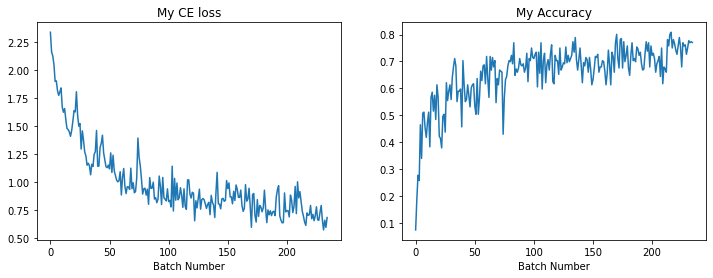

In [ ]:
from matplotlib import pyplot as plt

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(range(my_batches),my_batch_loss);
plt.title("My CE loss");
plt.xlabel("Batch Number");
plt.subplot(1,2,2)
plt.plot(range(my_batches),my_batch_acc);
plt.title("My Accuracy");
plt.xlabel("Batch Number");

# **My Model Test**

In [ ]:
set_cpu()

cpu


In [ ]:
eval_model_test(my_model)

After Dropout:
tensor([[0.0000, 0.0000, 0.1681,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.6203,  ..., 0.0000, 0.0000, 0.3357],
        ...,
        [0.0000, 0.0000, 0.3285,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])
Non Zero:
tensor([[0.0000, 0.0765, 0.5393,  ..., 0.0000, 0.2597, 0.3744],
        [2.2082, 0.0000, 0.0000,  ..., 0.0000, 0.3960, 0.0000],
        [0.0000, 0.7682, 0.0000,  ..., 0.7416, 0.8996, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0381, 0.1598],
        [0.0000, 0.0000, 0.6473,  ..., 0.0000, 0.2147, 0.4375],
        [1.8267, 0.2883, 0.0000,  ..., 0.0000, 0.8017, 0.0000]])


DropNorm forward res:
tensor([[0.0000, 0.0000, 0.2455,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 3.

(tensor(0.7286), tensor(0.7405))



---

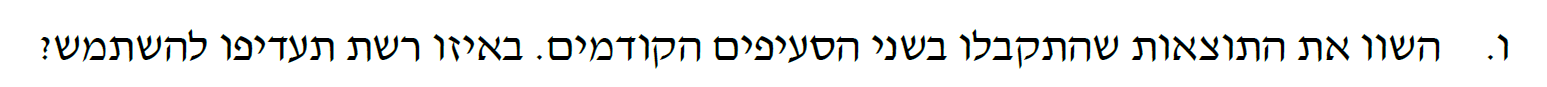

---



ככלל, אעדיף מודל מובנה על פני מודל שכתבתי בעצמי. זאת מכמה סיבות, למשל כמות האנשים ששיפרה את המודל עם הזמן והאופטמיזציות הכלולות בו.

במקרה הזה **המודל של פייטורץ'** השיג דיוק של **0.7682** לעומת דיוק של **0.7405** בלבד **במודל שלי** . לפיכך אעדיף את המודל של פייטורץ.




---

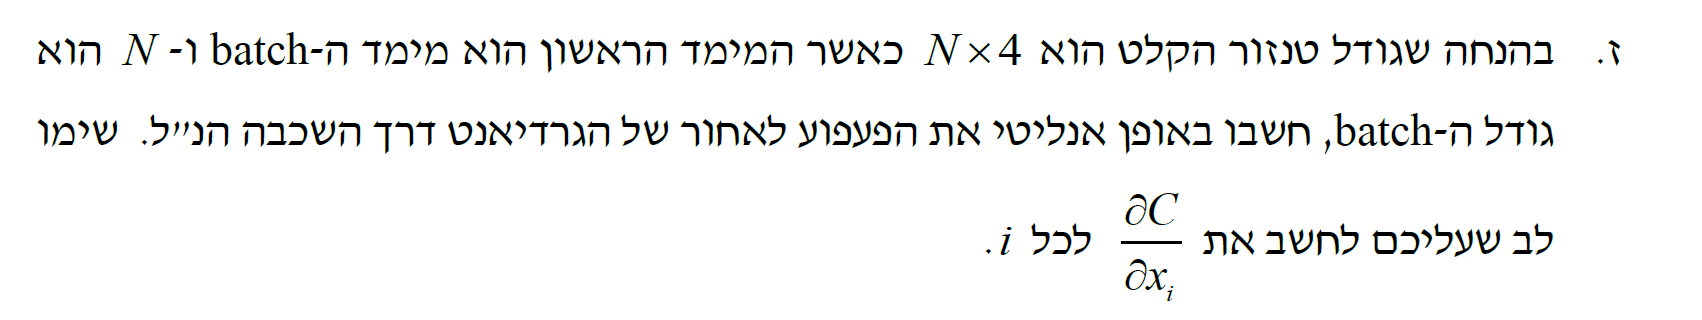

---

